In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

# Any results you write to the current directory are saved as output.

In [3]:
diab=pd.read_csv('../data/diabetes.csv')

### Checking The Data

In [4]:
diab.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Basic EDA

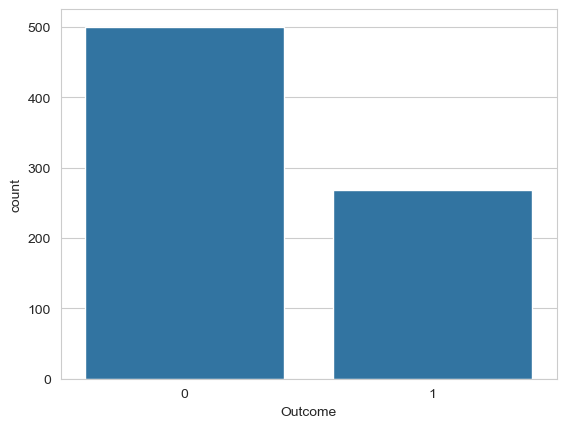

In [5]:
sns.countplot(x='Outcome',data=diab)
plt.show()

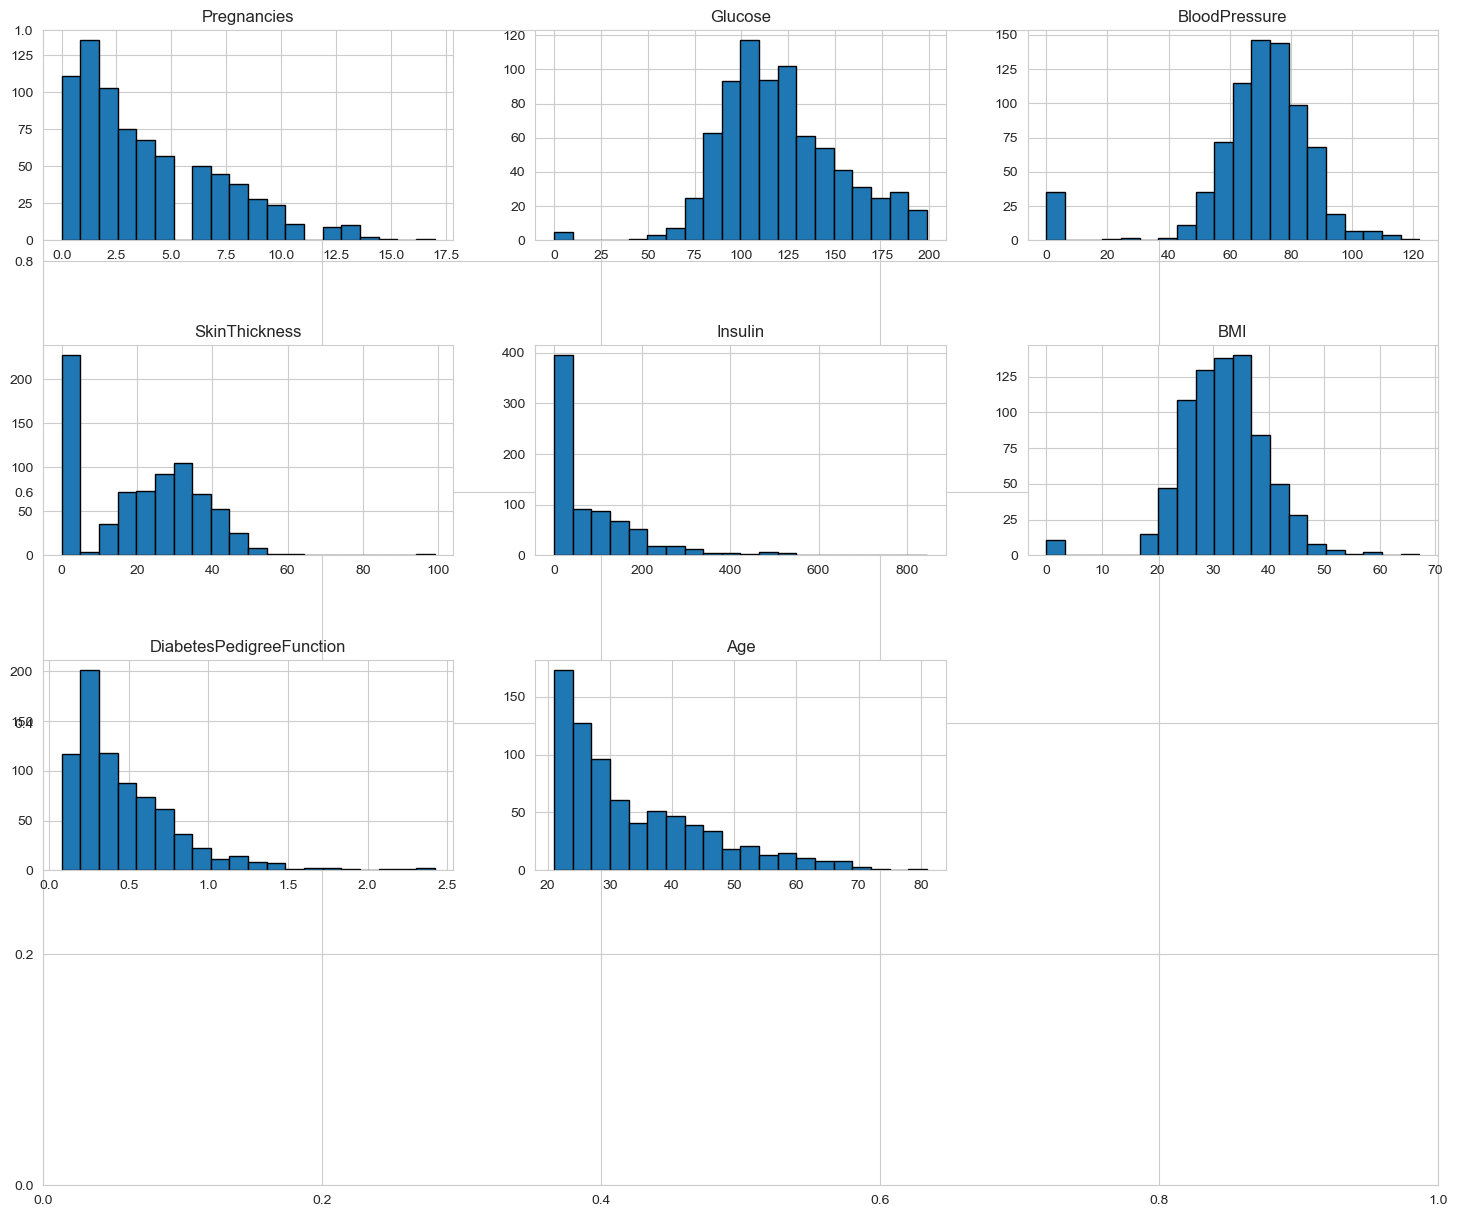

In [6]:
columns=diab.columns[:8]
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot((int(length/2)),3,int(j+1))
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    diab[i].hist(bins=20,edgecolor='black')
    plt.title(i)
plt.show()

### Correlation Matrix

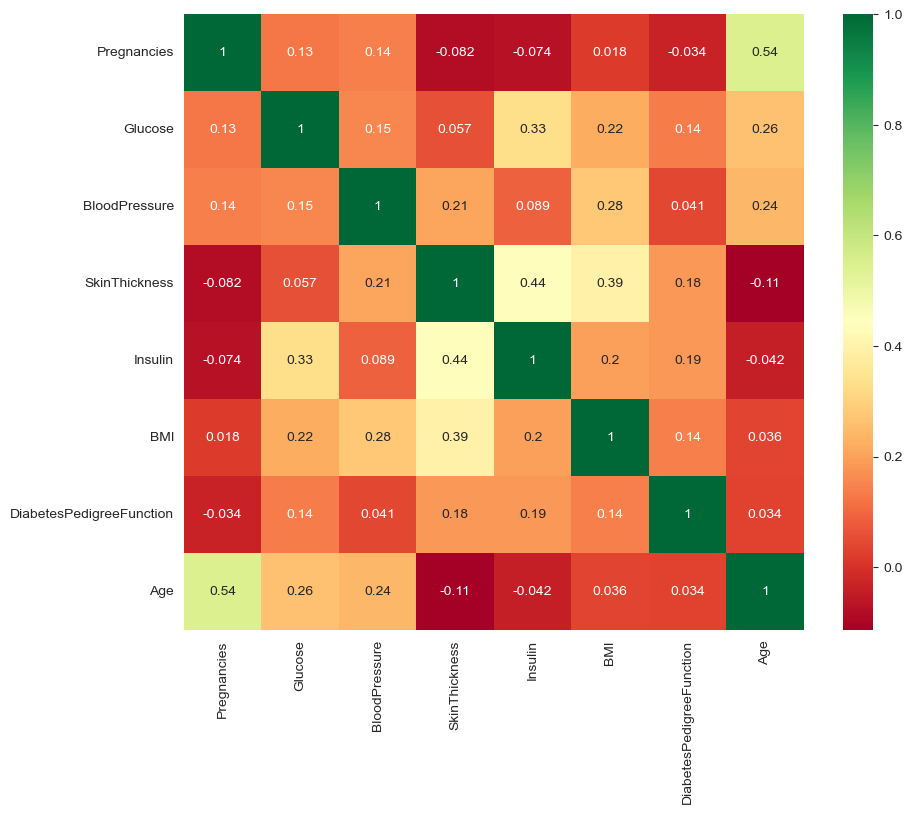

In [7]:
sns.heatmap(diab[diab.columns[:8]].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

The features look to be uncorrelated. So we cannot eliminate any features just by looking at the correlation matrix.

### Analysis Of Diabetic Cases

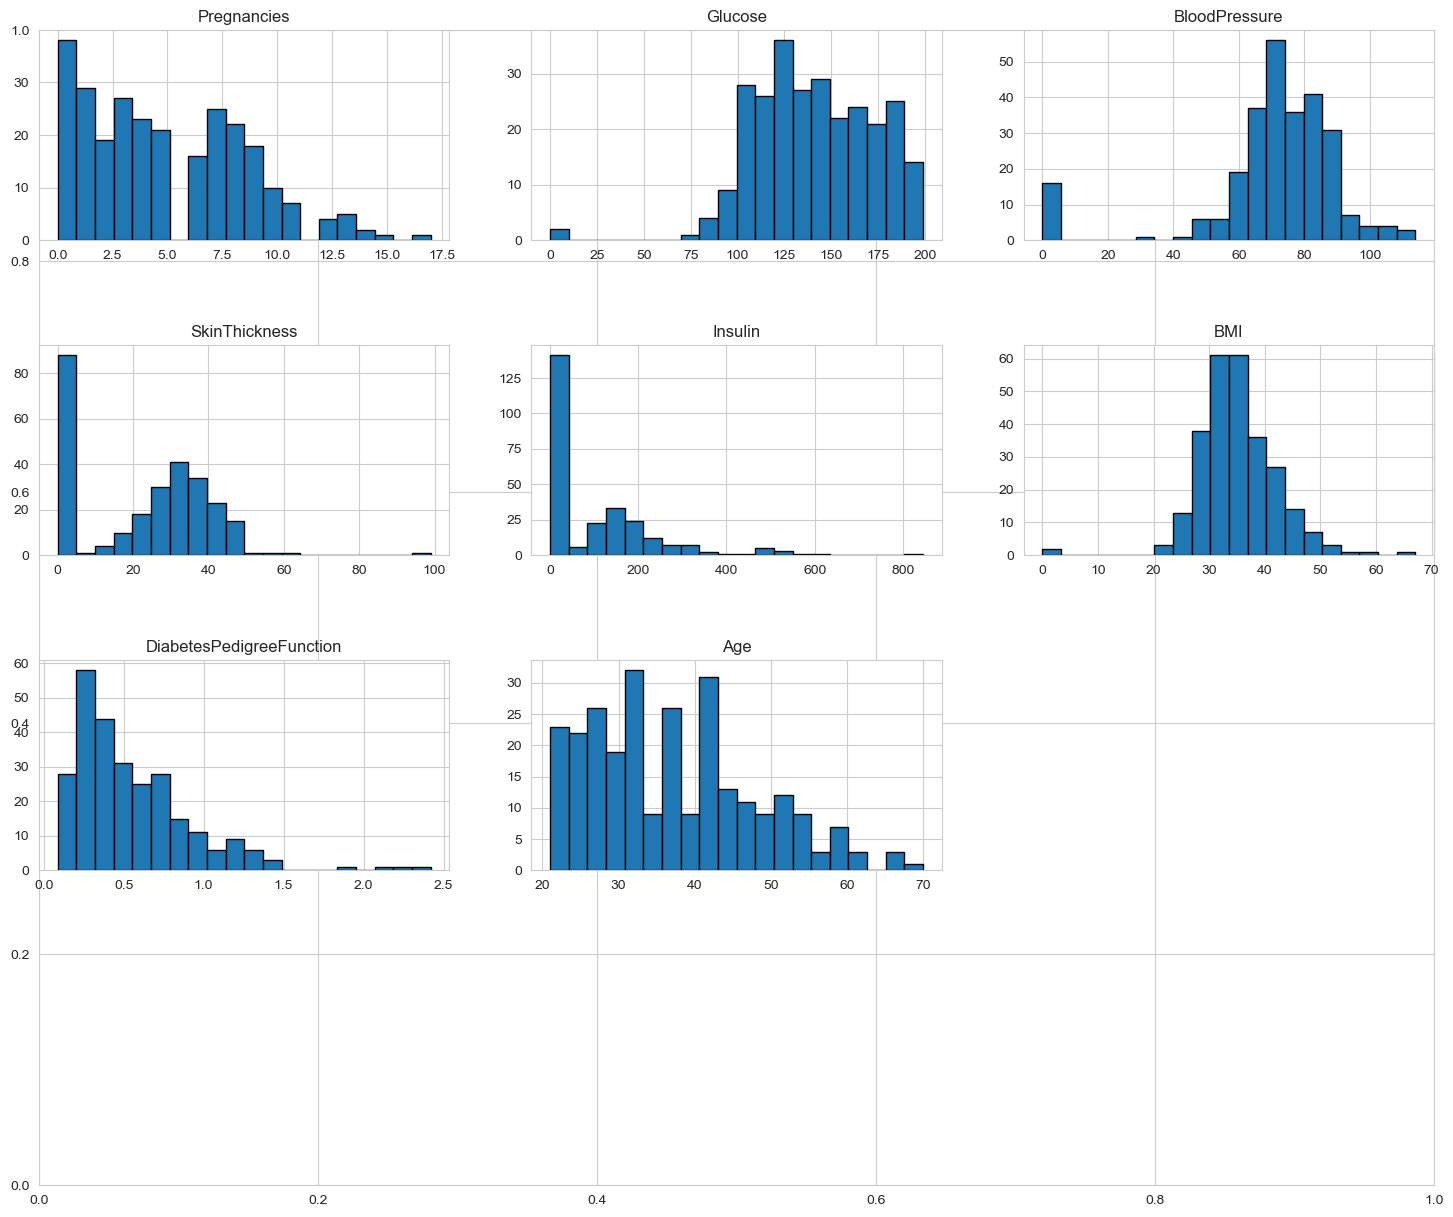

In [8]:
diab1=diab[diab['Outcome']==1]
columns=diab.columns[:8]
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot(int((length/2)),3,int(j+1))
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    diab1[i].hist(bins=20,edgecolor='black')
    plt.title(i)
plt.show()

### PairPlots:

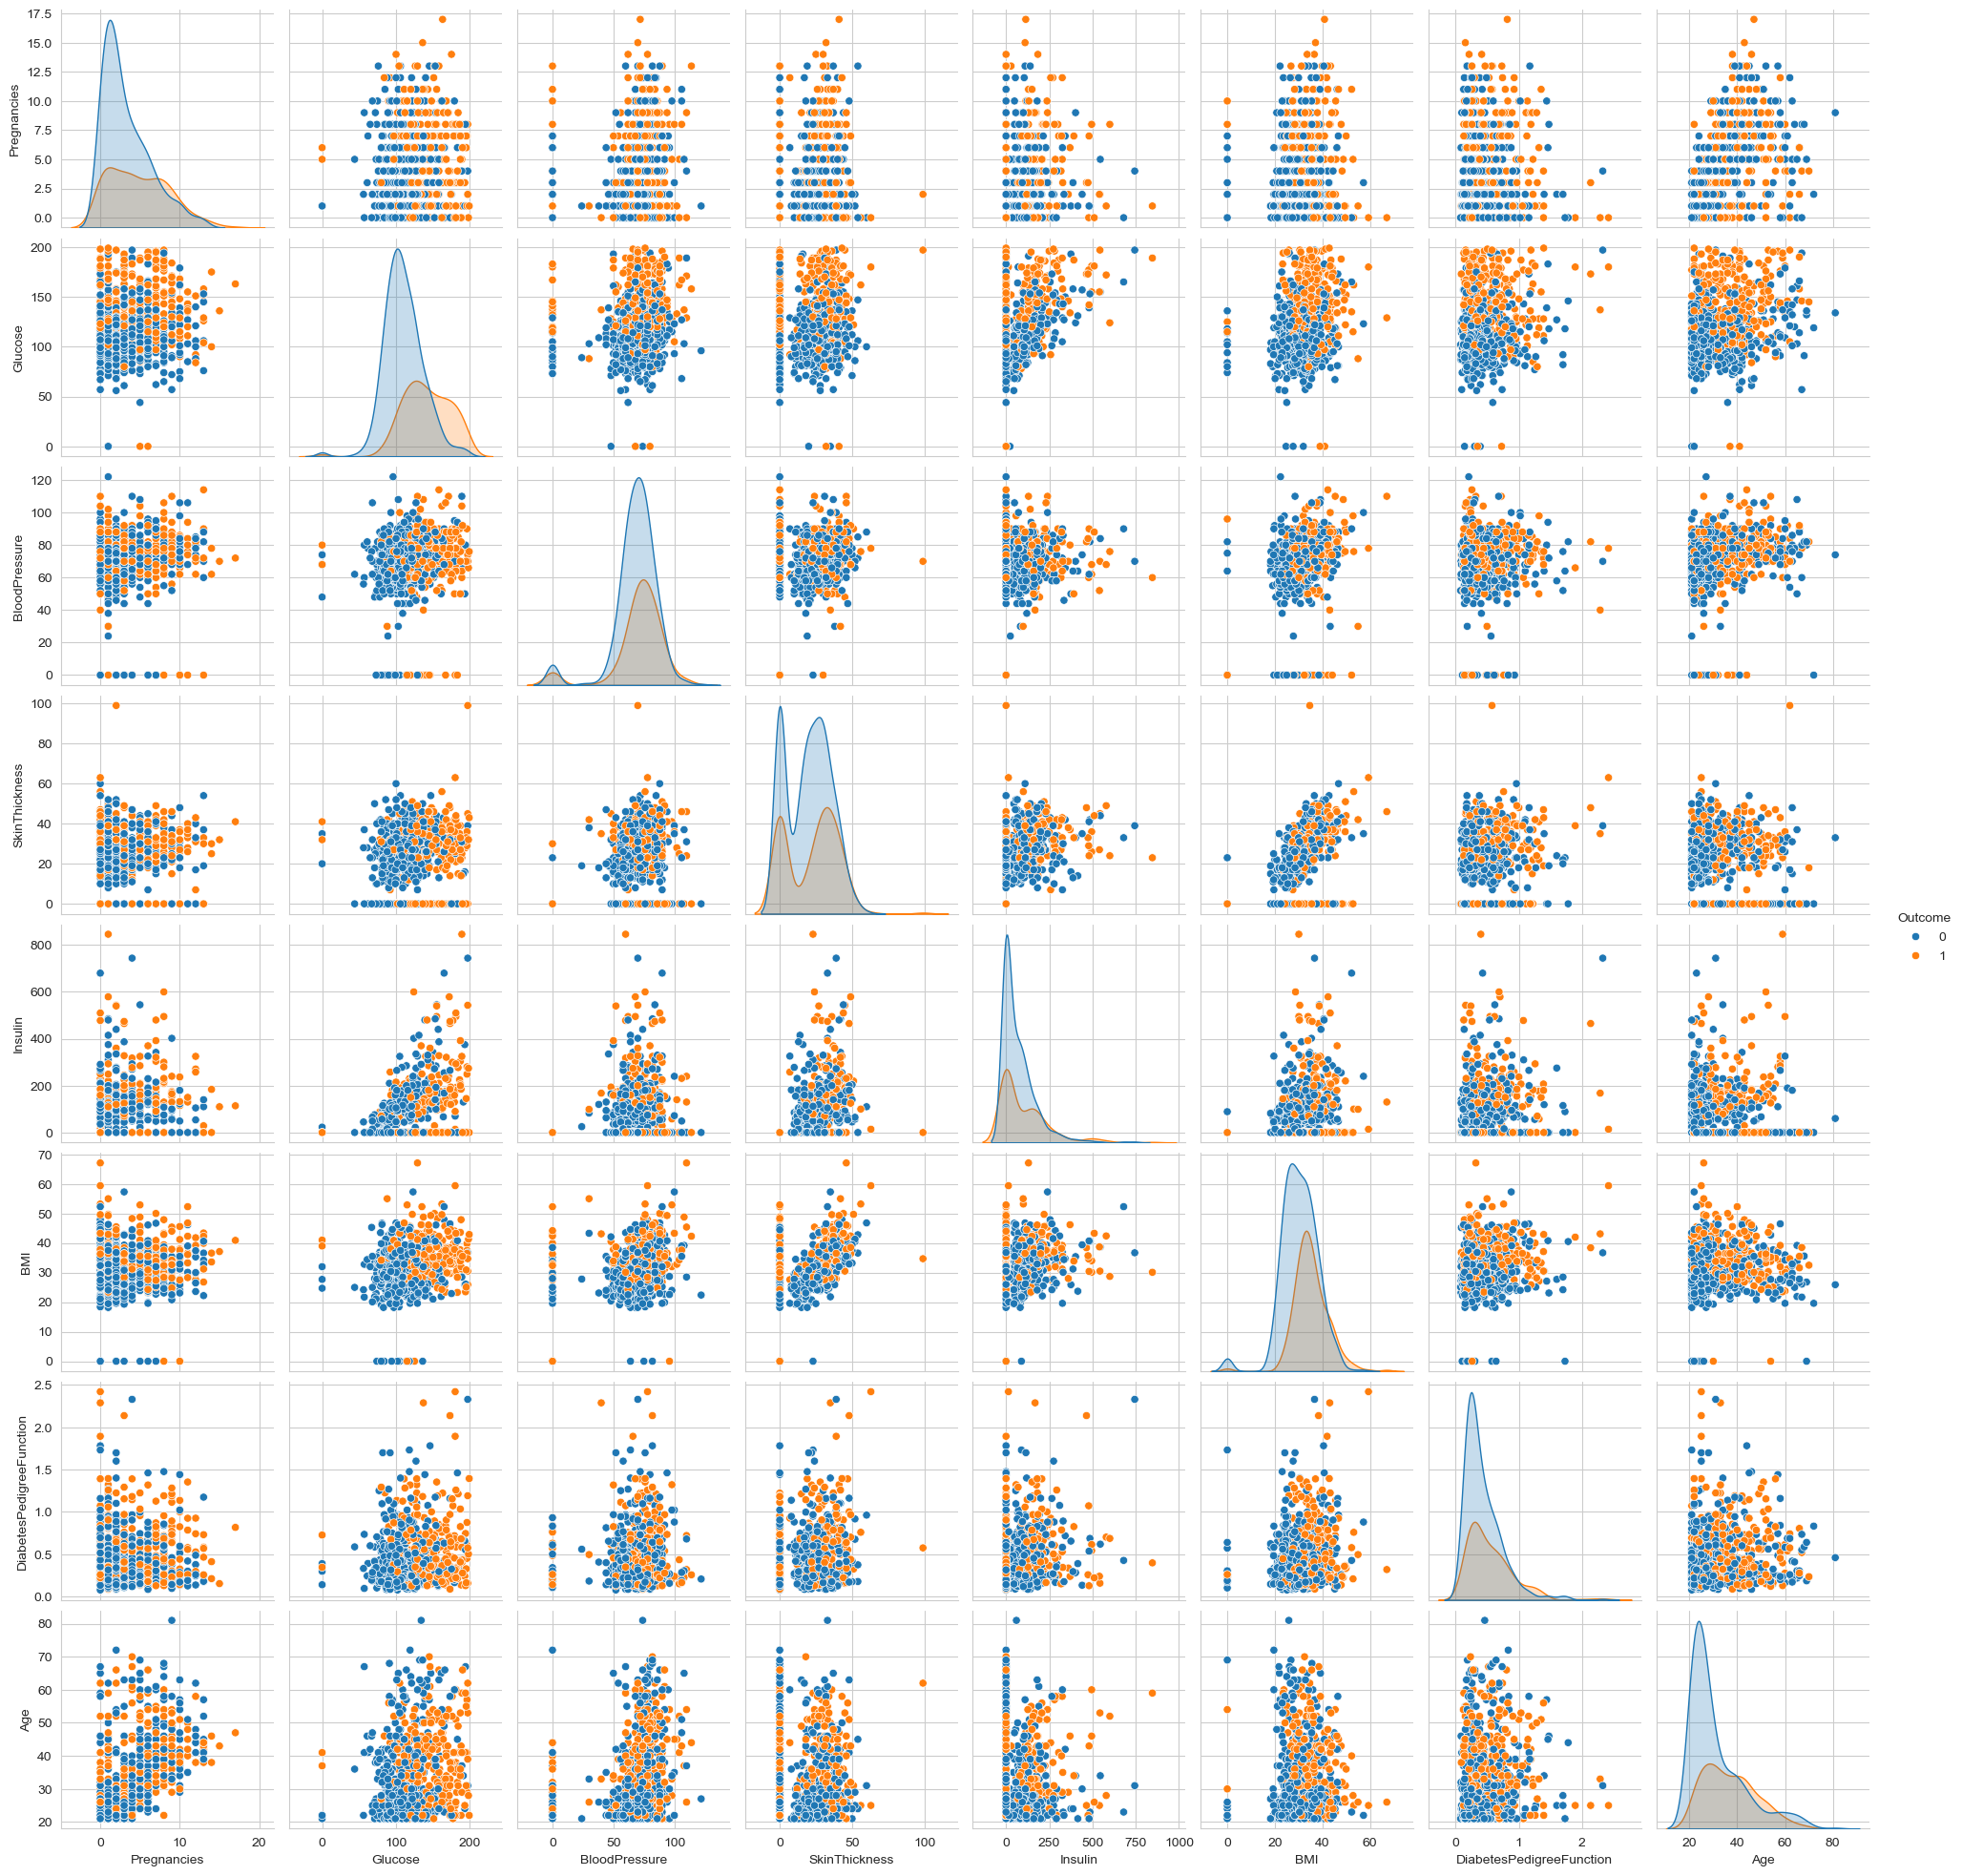

In [9]:
sns.pairplot(data=diab,hue='Outcome',diag_kind='kde')
plt.show()

The diagonal shows the distribution of the the dataset with the kernel density plots.

The scatter-plots shows the relation between each and every attribute or features taken pairwise. Are any two attributes able to clearly seperate the two outcome-class instances?

### Let's Do Some Predictive Modeling

In [10]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### Stratification:
When we split the dataset into train and test datasets, the split is completely random. Thus the instances of each class label or outcome in the train or test datasets is random. Thus we may have many instances of class 1 in training data and less instances of class 2 in the training data. So during classification, we may have accurate predictions for class1 but not for class2. Thus we stratify the data, so that we have proportionate data for all the classes in both the training and testing data.

In [11]:
outcome=diab['Outcome']
data=diab[diab.columns[:8]]
train,test=train_test_split(diab,test_size=0.25,random_state=0,stratify=diab['Outcome'])# stratify the outcome
train_X=train[train.columns[:8]]
test_X=test[test.columns[:8]]
train_Y=train['Outcome']
test_Y=test['Outcome']

In [12]:
train_X.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
432,1,80,74,11,60,30.0,0.527,22
453,2,119,0,0,0,19.6,0.832,72


In [13]:
train_Y.head(2)

432    0
453    0
Name: Outcome, dtype: int64

### Logistic Regression

In [14]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction,test_Y))

The accuracy of the Logistic Regression is 0.78125


In [15]:
# Calculate odds ratios by exponentiating the coefficients
odds_ratios = np.exp(model.coef_[0])

# Create a DataFrame with feature names and odds ratios
odds_ratio_df = pd.DataFrame({
    'Feature': train_X.columns,
    'Odds Ratio': odds_ratios
})

# Sort by odds ratio in descending order for better interpretation
odds_ratio_df = odds_ratio_df.sort_values('Odds Ratio', ascending=False)

# Display the odds ratios
odds_ratio_df

,Feature,Odds Ratio
6,DiabetesPedigreeFunction,2.234336
0,Pregnancies,1.121729
5,BMI,1.091555
1,Glucose,1.030911
7,Age,1.021906
4,Insulin,0.999951
3,SkinThickness,0.997065
2,BloodPressure,0.987346


### Using Standardisation

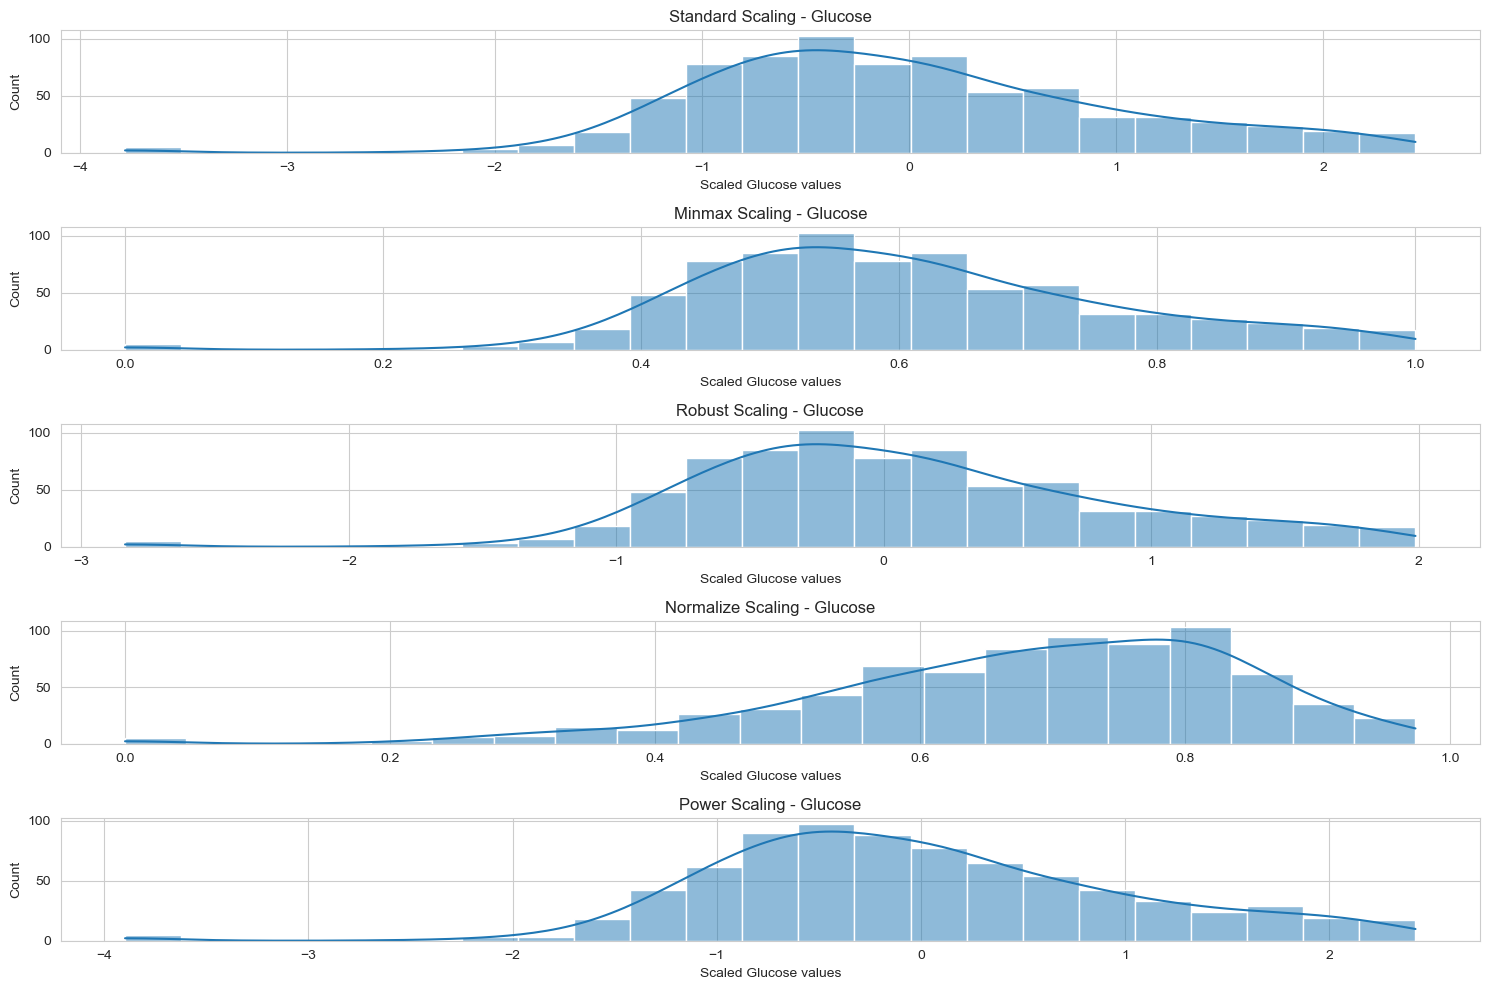

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, PowerTransformer

# Separate features and target from the diabetes dataset
features = diab.drop('Outcome', axis=1)
target = diab['Outcome']

# Create a dictionary to store different scaled versions of the data
scaled_features = {}

# 1. StandardScaler (Z-score normalization)
standard_scaler = StandardScaler()
scaled_features['standard'] = standard_scaler.fit_transform(features)

# 2. MinMaxScaler (scales features to a range, usually [0,1])
minmax_scaler = MinMaxScaler()
scaled_features['minmax'] = minmax_scaler.fit_transform(features)

# 3. RobustScaler (uses median and quantiles, robust to outliers)
robust_scaler = RobustScaler()
scaled_features['robust'] = robust_scaler.fit_transform(features)

# 4. Normalizer (scales each sample to unit norm - works on rows rather than columns)
normalizer = Normalizer()
scaled_features['normalize'] = normalizer.fit_transform(features)

# 5. Power Transform (makes data more Gaussian-like using Box-Cox or Yeo-Johnson)
power_transformer = PowerTransformer(method='yeo-johnson')
scaled_features['power'] = power_transformer.fit_transform(features)

# Choose one scaling method for the model (standard scaling is commonly used)
# Convert the scaled features back to a DataFrame to preserve column names
X = pd.DataFrame(scaled_features['standard'], columns=features.columns)
y = target

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=0, 
    stratify=y
)

# Visualize the effect of different scaling methods on a single feature
plt.figure(figsize=(15, 10))
feature_to_plot = 'Glucose'  # Choose a feature to visualize
feature_idx = features.columns.get_loc(feature_to_plot)

scaling_methods = list(scaled_features.keys())
for i, method in enumerate(scaling_methods):
    plt.subplot(len(scaling_methods), 1, i+1)
    sns.histplot(scaled_features[method][:, feature_idx], kde=True)
    plt.title(f'{method.capitalize()} Scaling - {feature_to_plot}')
    plt.xlabel(f'Scaled {feature_to_plot} values')
    
plt.tight_layout()
plt.show()